# CUDA Lab Assignment 2

## **Group members**

1. Areesha Asif
2. Abishek 

# CIFAR-10 Overview:
The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of 60,000 (32x32) color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into ten classes: **Airplane, Automobile (or car), Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.**

## 1. Importing Libraries

In [1]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import itertools

## 2. Data loading and Observation

In [2]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Counting the number of images in train and test datasets
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [4]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 50000
# Images Test:  10000


In [5]:
# Displaying the shape of a sample image and its label
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


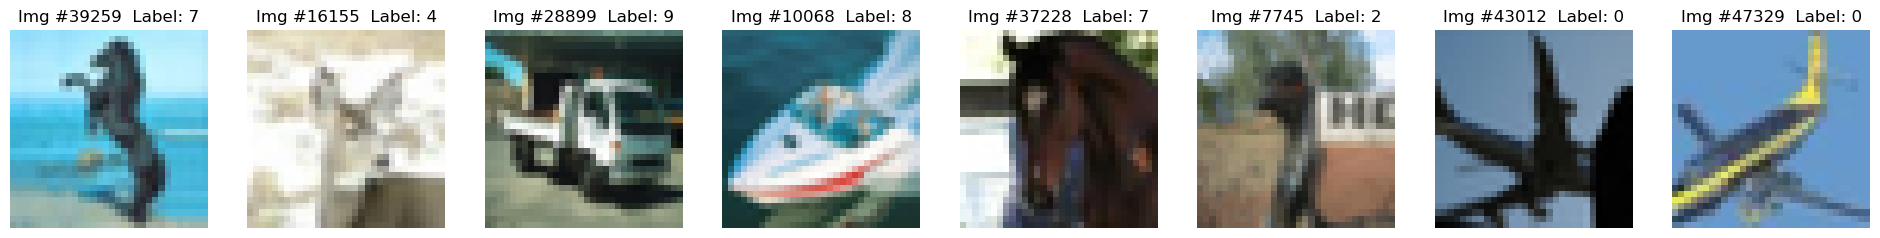

In [6]:
# Displaying a few random images from the training dataset


N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [7]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

In [8]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [9]:
# Checking the shape of a sample batch
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 3, 32, 32])
labels.shape = torch.Size([1024])


In [10]:
for i, (imgs, labels) in enumerate(eval_loader):
    print(f"Iterating batch #{i+1}, which has {len(labels)} elements")
    if i > 10:
        break

Iterating batch #1, which has 1024 elements
Iterating batch #2, which has 1024 elements
Iterating batch #3, which has 1024 elements
Iterating batch #4, which has 1024 elements
Iterating batch #5, which has 1024 elements
Iterating batch #6, which has 1024 elements
Iterating batch #7, which has 1024 elements
Iterating batch #8, which has 1024 elements
Iterating batch #9, which has 1024 elements
Iterating batch #10, which has 784 elements


Compare MLP here 

## 3. MLP Model Implementation
we use an naive 4-layer MLP for training, evaluation and visualization.

In [11]:
class Model(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=64, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim * 8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim * 8, out_features=hidden_dim * 8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim * 8, out_features=hidden_dim * 8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                # nn.Linear(in_features=hidden_dim * 2, out_features=hidden_dim),
                # nn.ReLU(),
                nn.Linear(in_features=hidden_dim * 8, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [12]:
model = Model(input_dim=3*32*32, hidden_dim=64, output_dim=10)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
count_model_params(model)

2103818

In [14]:
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.flatten(start_dim=1)  # reshaping to desired size
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

Imgs shape:         torch.Size([1024, 3, 32, 32])
Model input shape:  torch.Size([1024, 3072])
Model output shape: torch.Size([1024, 10])


In [19]:
# number of epochs and learning rate
NUM_EPOCHS = 100
LR = 3e-4

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=3*32*32, hidden_dim=64, output_dim=10)
model = model.to(device)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
# collect training, evaluation losses, accuracies during the training
train_loss_list = []
eval_loss_list = []
train_acc_list = []
eval_acc_list = []

# some layer-wise gradient statistics
max_grad_1 = []
mean_grad_1 = []
max_grad_2 = []
mean_grad_2 = []
max_grad_3 = []
mean_grad_3 = []
max_grad_4 = []
mean_grad_4 = []

loss_list = []

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # handle gradients
        for name, param in model.named_parameters():
            if param.requires_grad and ('bias' not in name) and name == 'layers.0.weight':
                # layers_grad.append(name)
                mean_grad_1.append(param.grad.abs().mean().item())
                # print(param.grad)
                max_grad_1.append(param.grad.abs().max().item())
                # print(max_grad)
            elif name == 'layers.2.weight':
                mean_grad_2.append(param.grad.abs().mean().item())
                max_grad_2.append(param.grad.abs().max().item())  
            elif name == 'layers.4.weight':
                mean_grad_3.append(param.grad.abs().mean().item())
                max_grad_3.append(param.grad.abs().max().item())
            elif name == 'layers.6.weight':
                mean_grad_4.append(param.grad.abs().mean().item())
                max_grad_4.append(param.grad.abs().max().item())
    
    
        # updating parameters
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    
    
    ####################################### Learning Curve Related ##########################################
    with torch.no_grad():
        train_loss = 0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)
            
            # 
            loss = criterion(preds, labels)
            train_loss += loss.item()
            #
            
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(100 * correct / total)

    # Compute evaluation accuracy & loss for this epoch
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in eval_loader:  # assuming you have an eval_loader
            imgs, labels = imgs.to(device), labels.to(device)
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)
            loss = criterion(preds, labels)
            eval_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        eval_loss_list.append(eval_loss / len(eval_loader))
        eval_acc_list.append(100 * correct / total)
    ##################################################################

Epoch 100 Iter 49: loss 0.41137. : 100%|████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.75it/s]


In [23]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

## 3.1 Testing Evaluation and Data Plot
### 3.1.1 Visualize Gradient Change

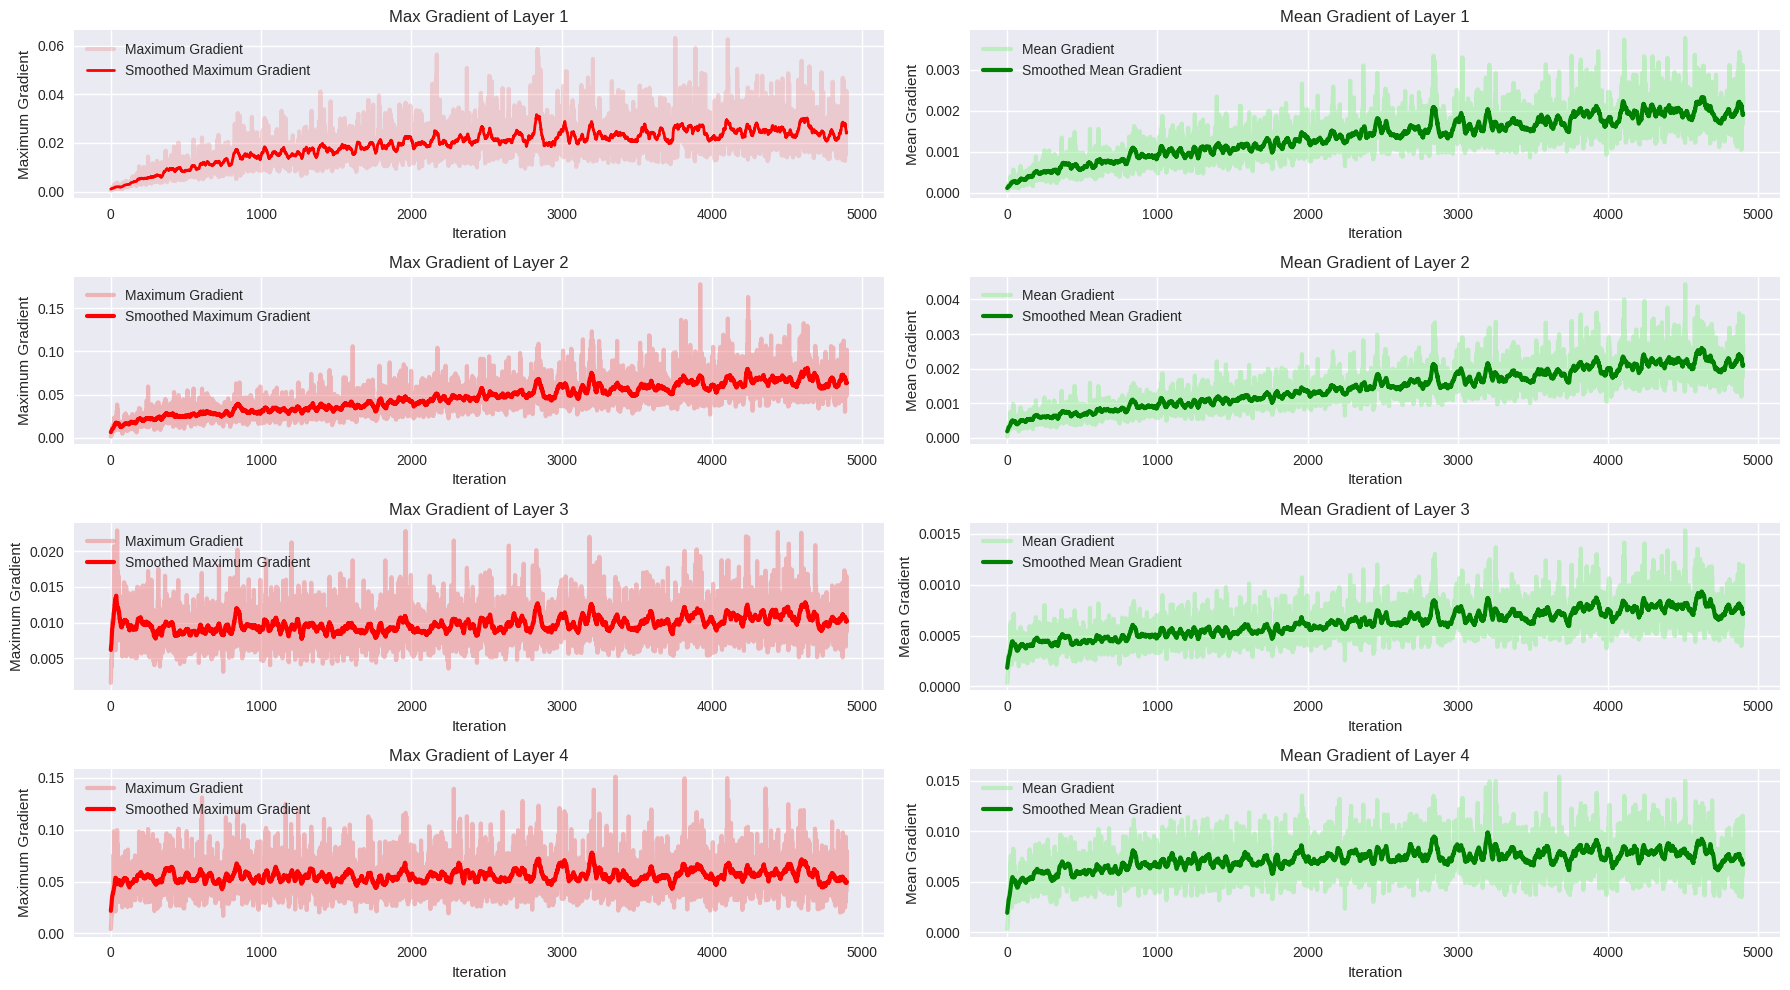

In [24]:
plt.style.use('seaborn')
fig, ax = plt.subplots(4,2)
fig.set_size_inches(18,10)

smooth_max_1 = smooth(max_grad_1, 31)
smooth_max_2 = smooth(max_grad_2, 31)
smooth_max_3 = smooth(max_grad_3, 31)
smooth_max_4 = smooth(max_grad_4, 31)

smooth_mean_1 = smooth(mean_grad_1, 31)
smooth_mean_2 = smooth(mean_grad_2, 31)
smooth_mean_3 = smooth(mean_grad_3, 31)
smooth_mean_4 = smooth(mean_grad_4, 31)


ax[0,0].plot(max_grad_1, c="lightcoral", label="Maximum Gradient", linewidth=3, alpha=0.3)
ax[0,0].plot(smooth_max_1, c="red", label="Smoothed Maximum Gradient", linewidth=2)
ax[0,0].legend(loc="upper left")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Maximum Gradient")
ax[0,0].set_title("Max Gradient of Layer 1")

ax[0,1].plot(mean_grad_1, c="lightgreen", label="Mean Gradient", linewidth=3, alpha=0.5)
ax[0,1].plot(smooth_mean_1, c="green", label="Smoothed Mean Gradient", linewidth=3)
ax[0,1].legend(loc="best")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Mean Gradient")
ax[0,1].set_title("Mean Gradient of Layer 1")

ax[1,0].plot(max_grad_2, c="lightcoral", label="Maximum Gradient", linewidth=3, alpha=0.5)
ax[1,0].plot(smooth_max_2, c="red", label="Smoothed Maximum Gradient", linewidth=3)
ax[1,0].legend(loc="best")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Maximum Gradient")
ax[1,0].set_title("Max Gradient of Layer 2")

ax[1,1].plot(mean_grad_2, c="lightgreen", label="Mean Gradient", linewidth=3, alpha=0.5)
ax[1,1].plot(smooth_mean_2, c="green", label="Smoothed Mean Gradient", linewidth=3)
ax[1,1].legend(loc="best")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Mean Gradient")
ax[1,1].set_title("Mean Gradient of Layer 2")

ax[2,0].plot(max_grad_3, c="lightcoral", label="Maximum Gradient", linewidth=3, alpha=0.5)
ax[2,0].plot(smooth_max_3, c="red", label="Smoothed Maximum Gradient", linewidth=3)
ax[2,0].legend(loc="best")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Maximum Gradient")
ax[2,0].set_title("Max Gradient of Layer 3")

ax[2,1].plot(mean_grad_3, c="lightgreen", label="Mean Gradient", linewidth=3, alpha=0.5)
ax[2,1].plot(smooth_mean_3, c="green", label="Smoothed Mean Gradient", linewidth=3)
ax[2,1].legend(loc="best")
ax[2,1].set_xlabel("Iteration")
ax[2,1].set_ylabel("Mean Gradient")
ax[2,1].set_title("Mean Gradient of Layer 3")

ax[3,0].plot(max_grad_4, c="lightcoral", label="Maximum Gradient", linewidth=3, alpha=0.5)
ax[3,0].plot(smooth_max_4, c="red", label="Smoothed Maximum Gradient", linewidth=3)
ax[3,0].legend(loc="best")
ax[3,0].set_xlabel("Iteration")
ax[3,0].set_ylabel("Maximum Gradient")
ax[3,0].set_title("Max Gradient of Layer 4")

ax[3,1].plot(mean_grad_4, c="lightgreen", label="Mean Gradient", linewidth=3, alpha=0.5)
ax[3,1].plot(smooth_mean_4, c="green", label="Smoothed Mean Gradient", linewidth=3)
ax[3,1].legend(loc="best")
ax[3,1].set_xlabel("Iteration")
ax[3,1].set_ylabel("Mean Gradient")
ax[3,1].set_title("Mean Gradient of Layer 4")

plt.tight_layout()
plt.show()

The graph above shows that initially, the mean gradient increased, followed by a trend of decrease marked by significant variations. Overall, the gradient's intensity peaked at the second layer of our architecture before notably diminishing in the later layers. Similar patterns were observed for the maximum gradient as well.

### 3.1.2 Training Progress

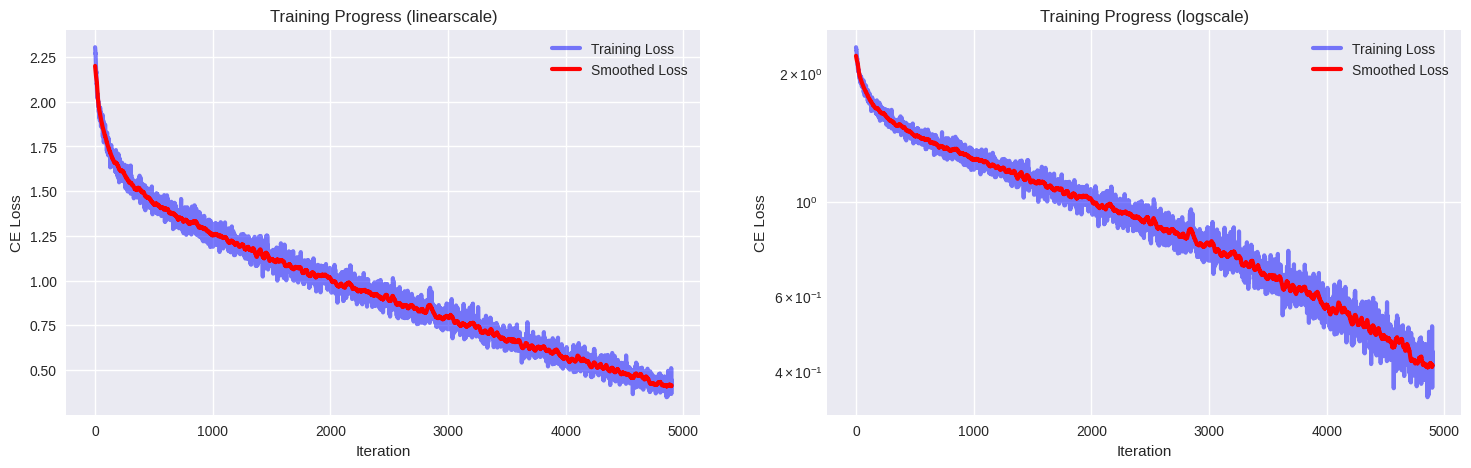

In [25]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(loss_list, 31)
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

From the training loss alone we cannot get too much information but our architecture is effective to some extent and the model is fitting the training data better and better.

### 3.1.3 Plotting the Learning Curve (Epochs vs Loss/Accuracy)

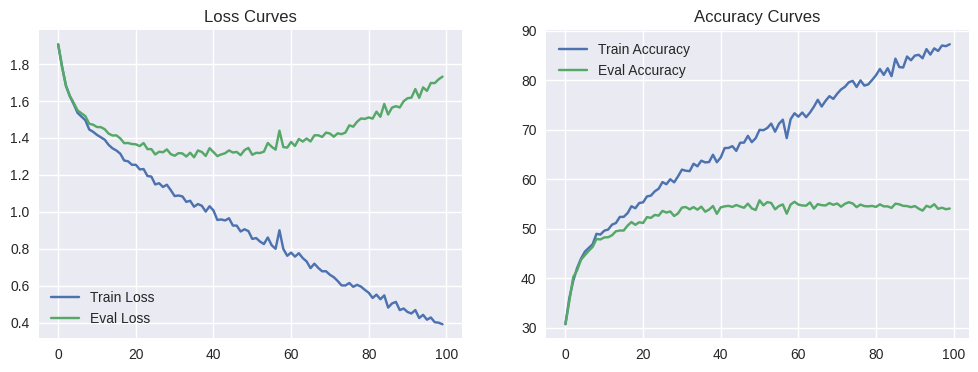

In [26]:
plt.style.use('seaborn')
# Train and Eval Loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(eval_loss_list, label='Eval Loss')
plt.legend()
plt.title('Loss Curves')

# Train and Eval Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(eval_acc_list, label='Eval Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

From these results, combined with the training progress results we got above, we can notice a very clear indication of overfitting which happened at very early epochs. We believe that this is because the limitation of a naive MLp architecture and the complexity of the task compared to MNIST dataset.

## 3.2 Evaluating Network on Test Data

In [27]:
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
        # print(preds.shape)
        
        pred_labels = torch.argmax(preds, dim=-1)
        # print(pred_labels[:15])
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.72it/s]

Test accuracy: 54.09%


we did not get a really good accuracy since the model started to show overfitting at very early stage. And we continue our experiment to see if, through the optuna optimization, we can obtain a good combination of parameters.

## 3.3 Confusion Matrix

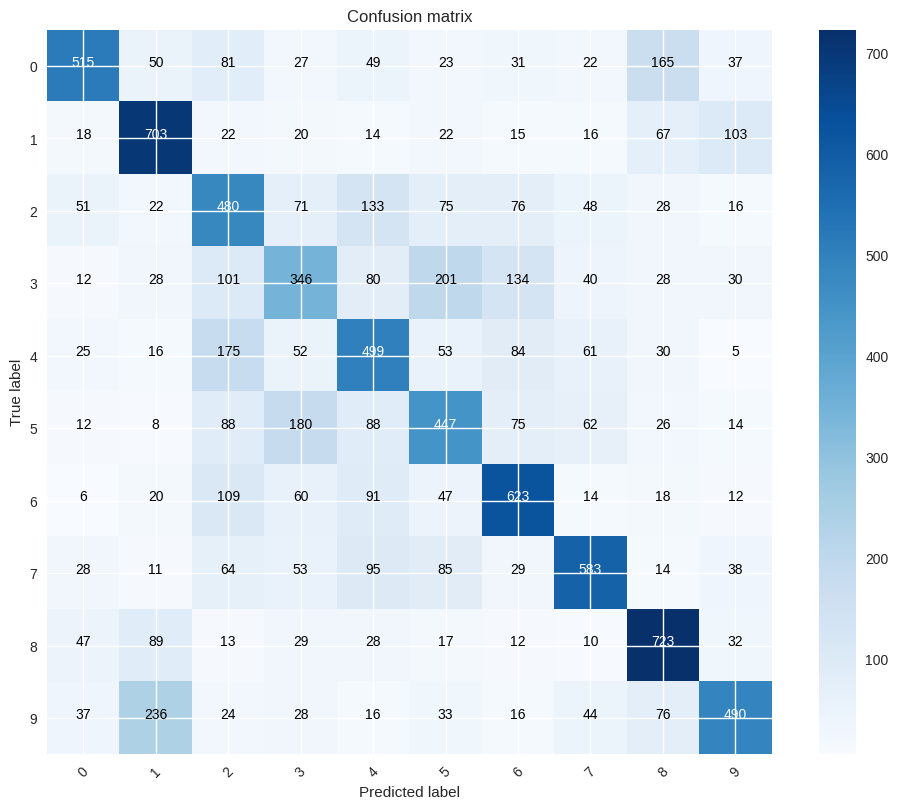

In [28]:
# Confusion matrix calculation using PyTorch
def confusion_matrix(preds, labels, num_classes):
    conf_matrix = torch.zeros(num_classes, num_classes)
    for t, p in zip(labels.view(-1), preds.view(-1)):
        conf_matrix[t.long(), p.long()] += 1
    return conf_matrix

# Gather all predictions and true labels from the test data
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in eval_loader:  # Make sure you use test_loader for testing data
        imgs, labels = imgs.to(device), labels.to(device)
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
        _, predicted = torch.max(preds.data, 1)
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

# Compute the confusion matrix
cm = confusion_matrix(torch.Tensor(all_preds), torch.Tensor(all_labels), 10)

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = [str(i) for i in range(10)]
plot_confusion_matrix(cm.numpy(), classes)

# 4.CNN with dropout
Here we are going to implement the CNN Model-Different CNN Networks are used here to understand Accuracy.

In [11]:
class CNN(nn.Module):            # Accuracy of 82% Reached.USING This Network
    def __init__(self):
        super(CNN, self).__init__()
    

        # Convolutional Layers
        self.conv_layer = nn.Sequential(
            
            # 1st Convolution Layer
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),         
            nn.ReLU(inplace=True),
            
            
            # 2nd Convolution Layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  #. A kernelsize of 2 allows the pooling layer toretain important features. 
    
            
            # 3rd Convolution Layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),        

            # 4th Convolution Layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            
            # 5th Convolution Layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 6th Convolution Layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), #spatial dimensions are reduced to 4×4 (for simplicity) and the number of channels is 256.
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Layers
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),     # dropout rate can be changed to 0.2
            nn.Linear(4*4*256, 1024), #Input here is 4*4*256(4096) and output is 1024 or can use 2048.
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),    # 2048 to 1024
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)      #1024 to 10
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv_layer(x)
    
        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc_layer(x)

        return x
    
# Helper function to count the number of learnable parameters in the model
def count_model_params(model):
    """ Counting the number of learnable parameters in an nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Count parameters with gradients
    return num_params     

   
    kernal size 3 is commonly used.It is sufficient to capture local features and patterns in the input.
            
    BatchNorm helps normalize the input data.BatchNorm is applied after the first,third and fifth convolutional 
    layers. This is a common practice, and applying it judiciously can lead to an efficient and 
    effective neural network.
            
    Using ReLU only in the fully connected layers (dense layers) at the end of the network is a valid choice, and 
    it's a common practice in many neural network architectures.ReLU is applied after each convolutional layer 
     #to introduce non-linearity and enable the network to learn complex features from the input images.  
    
    
    dropout is to introduce some level of uncertainty or randomness during training. By randomly "dropping out" units, 
    the network is forced to learn a more robust and distributed representation of the data, 
    as it cannot rely too heavily on any one particular feature or neuron.
    nn.Dropout2d is used to apply dropout to 2D input (which is typical for convolutional layers).
    The p parameter represents the probability of dropping out a neuron

In [12]:
cnn = CNN()
cnn

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [13]:
params = count_model_params(cnn)
print(f"Model has {params} learnable parameters")

Model has 5852170 learnable parameters


Training the Data

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [15]:
LR = 0.001  # learning rate we can vary from 0.01 to 0.001
EPOCHS = 25
EVAL_FREQ = 1
SAVE_FREQ = 10

In [16]:
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [17]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []

    with torch.no_grad():                     #gradients are not calculated during the evaluation phase.Increase Memory,Speed.
        for images, labels in eval_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass only to get logits/output
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Get predictions from the maximum value
            preds = torch.argmax(outputs, dim=1)
            correct += len( torch.where(preds==labels)[0] )
            total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """

    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats

In [18]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [20]:
torch.cuda.empty_cache()

In [23]:
loss_hist = []

# Gradient statistics lists for each convolutional layer
max_grads = {f'conv{i}': [] for i in range(1, 7)}
mean_grads = {f'conv{i}': [] for i in range(1, 7)}

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters, ie, Backward pass and Optiize
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(images) #preds

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Handle gradients
        for name, param in cnn.named_parameters():
            if param.requires_grad and 'weight' in name:
                layer_number = None
                if 'conv_layer.0' in name:  # First Conv layer
                    layer_number = 1
                elif 'conv_layer.3' in name:  # Second Conv layer
                    layer_number = 2
                elif 'conv_layer.6' in name:  # Third Conv layer
                    layer_number = 3
                elif 'conv_layer.9' in name:  # Fourth Conv layer
                    layer_number = 4
                elif 'conv_layer.13' in name:  # Fifth Conv layer
                    layer_number = 5
                elif 'conv_layer.16' in name:  # Sixth Conv layer
                    layer_number = 6

                if layer_number:
                    layer_key = f'conv{layer_number}'
                    mean_grads[layer_key].append(param.grad.abs().mean().item())
                    max_grads[layer_key].append(param.grad.abs().max().item())


        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        if i % 10 == 0:
            torch.cuda.empty_cache()

    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

  0%|                                                                                            | 0/49 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.75 GiB total capacity; 326.97 MiB already allocated; 7.56 MiB free; 334.00 MiB reserved in total by PyTorch)

Now we will plot the graphs

# 4.1 Training progress

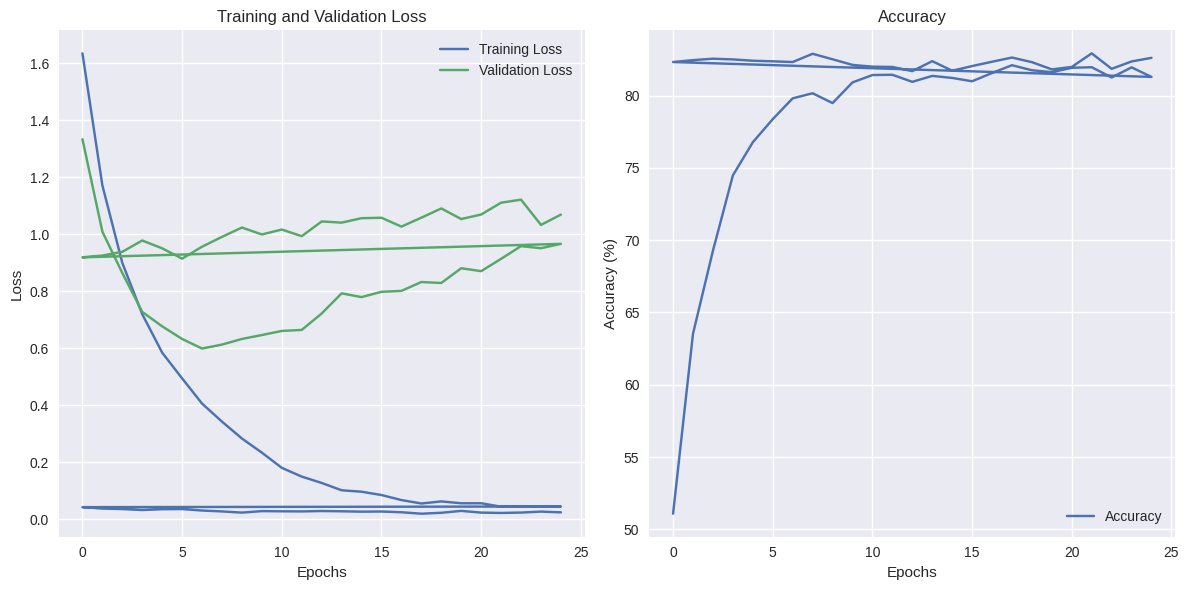

In [58]:
# Extract data from the stats dictionary
epochs = stats["epoch"]
train_loss = stats["train_loss"]
valid_loss = stats["valid_loss"]
accuracy = stats["accuracy"]

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Observations for the above Plot

Validation Loss increasing after 15 epochs
#1).Overfitting-model learns the training data too well, including its noise and outliers, 
to the point that it performs poorly on unseen data (validation set).

#2).Learning Rate can be higher.

#3).Complex Structure used here-complex model can capture noise in the training data, leading to overfitting.
simplifying the model architecture or using regularization techniques like dropout.

#4).Running with Less Epochs.





Visualizing First and Second Layer Kernels

# 4.2 Visualization of Layer-wise Gradient Statistics

In [59]:
# Function to smooth the gradients for better visualization
def smoothCnn(f, K=5):
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

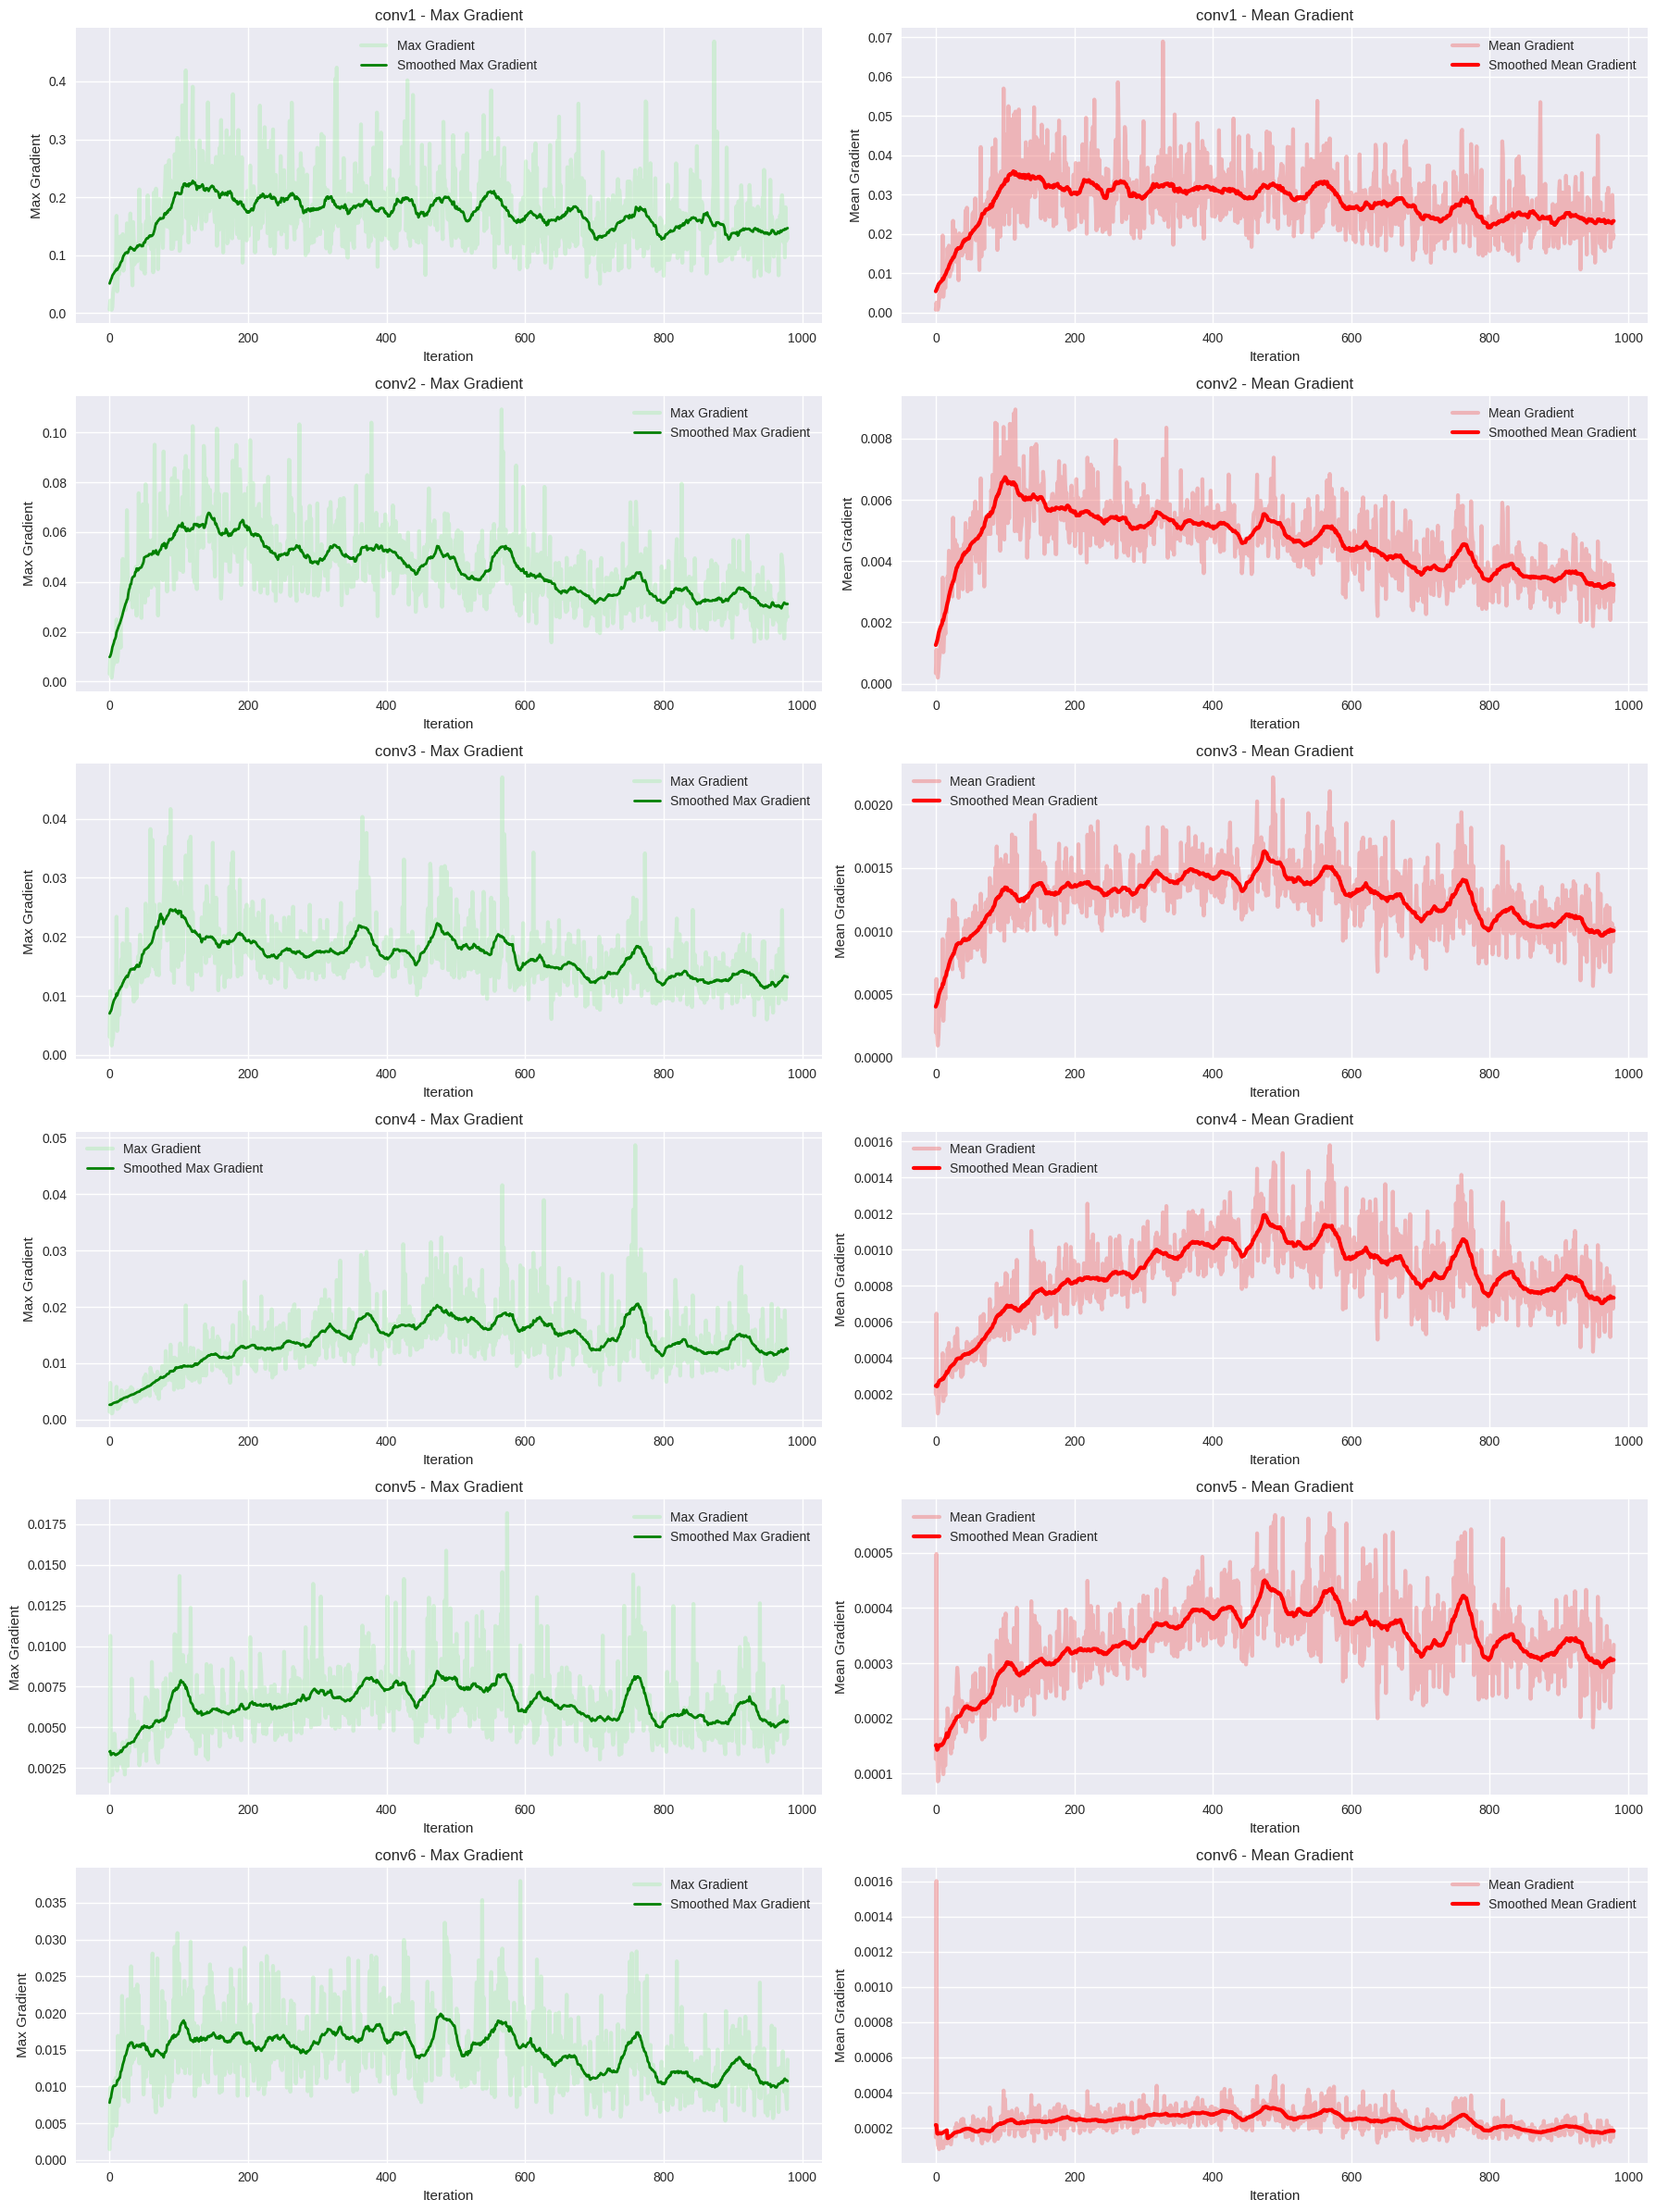

In [81]:
plt.style.use('seaborn')
fig, axes = plt.subplots(len(max_grads), 2, figsize=(18, len(max_grads) * 4))

for i, layer in enumerate(sorted(max_grads.keys())):
    if not max_grads[layer] or not mean_grads[layer]:  # Check if the lists are empty
        print(f"No gradients collected for {layer}, skipping plot.")
        continue

    # Smooth gradients for better visualization
    smooth_max_grads = smoothCnn(max_grads[layer], 31)
    smooth_mean_grads = smoothCnn(mean_grads[layer], 31)

    axes[i, 0].plot(max_grads[layer], c="lightgreen", label='Max Gradient', alpha=0.3, linewidth=3)
    axes[i, 0].plot(smooth_max_grads, c="green", label='Smoothed Max Gradient', linewidth=2)
    axes[i, 0].set_title(f'{layer} - Max Gradient')
    axes[i, 0].set_xlabel('Iteration')
    axes[i, 0].set_ylabel('Max Gradient')
    axes[i, 0].legend()

    axes[i, 1].plot(mean_grads[layer], c="lightcoral", label='Mean Gradient', alpha=0.5, linewidth=3)
    axes[i, 1].plot(smooth_mean_grads, c="red", label='Smoothed Mean Gradient', linewidth=3)
    axes[i, 1].set_title(f'{layer} - Mean Gradient')
    axes[i, 1].set_xlabel('Iteration')
    axes[i, 1].set_ylabel('Mean Gradient')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


# 4.3 Training Progress

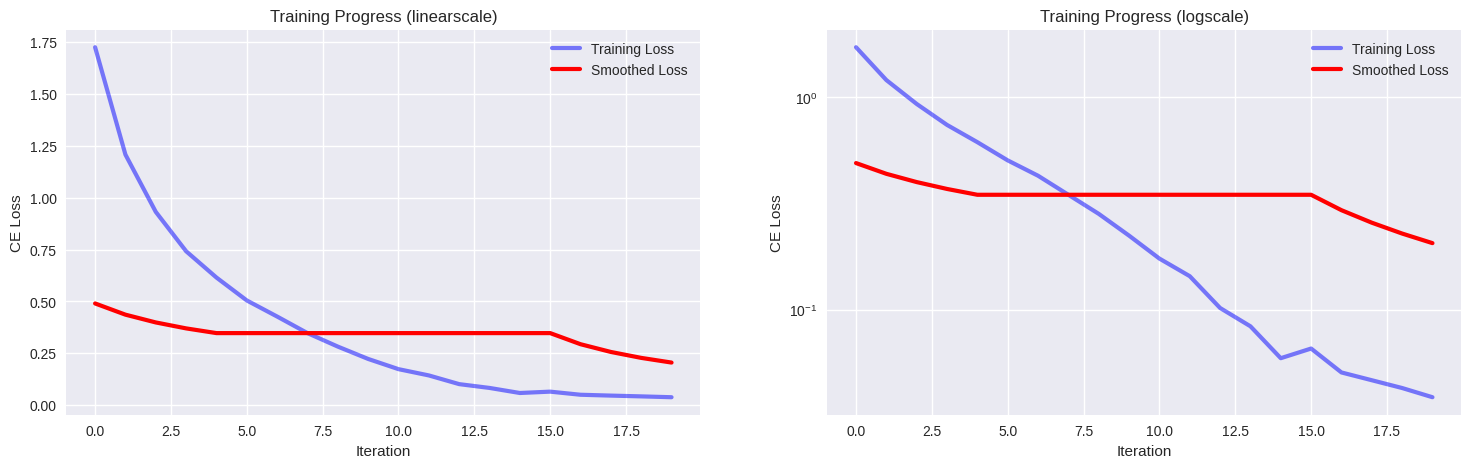

In [82]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_hloss = smooth(loss_hist, 31)
ax[0].plot(loss_hist, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_hloss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_hist, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_hloss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

# 4.4 Confusion matrix

In [61]:
def confusion_matrix(preds, labels, num_classes):
    conf_matrix = torch.zeros(num_classes, num_classes)
    for t, p in zip(labels.view(-1), preds.view(-1)):
        conf_matrix[t.long(), p.long()] += 1
    return conf_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


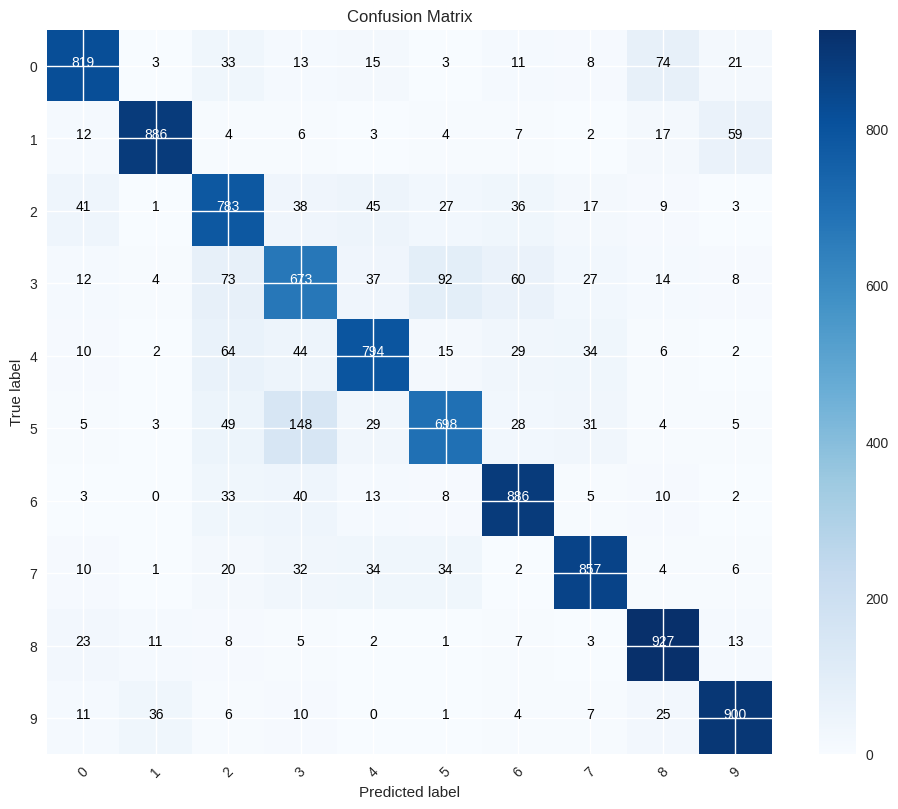

In [62]:
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in eval_loader:
        imgs, labels = imgs.to(device), labels.to(device)
       # flattened_imgs = imgs.flatten(start_dim=1)
        preds = cnn(imgs)
        _, predicted = torch.max(preds.data, 1)
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

cm = confusion_matrix(torch.Tensor(all_preds), torch.Tensor(all_labels), 10)
classes = [str(i) for i in range(10)]
plot_confusion_matrix(cm.numpy(), classes)


## 5. Visualizing Conv Layer Kernels

Visualizing first Conv layer kernels with tensor shape torch.Size([32, 3, 3, 3])


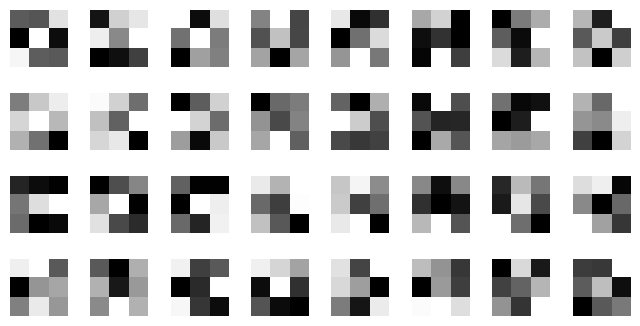

Visualizing Second Conv layer kernels with tensor shape torch.Size([64, 32, 3, 3])


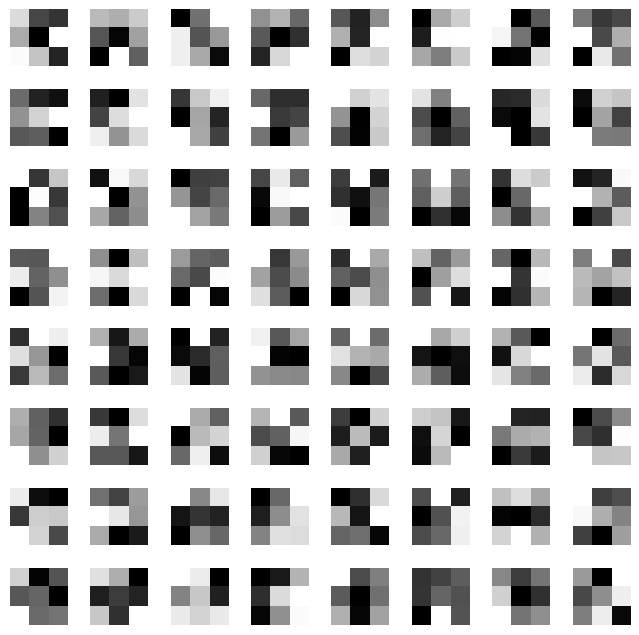

In [63]:
def plot_kernels(tensor, num_cols=8):
    num_kernels = tensor.size(0)
    num_rows = num_kernels // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i in range(num_kernels):
        ax = axs[i // num_cols, i % num_cols]
        ax.imshow(tensor[i, 0].cpu(), cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)    
    plt.show()

model = CNN()

# Access the weights of the first and second convolutional layers
first_conv_layer_weights = model.conv_layer[0].weight.data
second_conv_layer_weights = model.conv_layer[3].weight.data

# Display the kernels of the first convolutional layer
print(f"Visualizing first Conv layer kernels with tensor shape {first_conv_layer_weights.shape}")
plot_kernels(first_conv_layer_weights)

# Display the kernels of the second convolutional layer
print(f"Visualizing Second Conv layer kernels with tensor shape {second_conv_layer_weights.shape}")
plot_kernels(second_conv_layer_weights)

# Observations

Kernels, also known as filters, are small-sized matrices used to scan the input data in the 
convolutional layers of a CNN. Here are some reasons why visualizing kernels is beneficial:

1)Feature Visualization:Kernels act as feature detectors. Visualizing them helps understand what specific patterns or 
features they are designed to recognize in the input data.
2)Interpretability:Kernel visualization provides interpretability by showing which patterns activate specific filters. 
This is crucial for understanding what the network is focusing on during the learning process.
3)Model Understanding:Analyzing kernel visualizations aids in understanding the hierarchical nature of feature extraction in 
CNNs. Lower layers often capture basic features, while deeper layers learn complex and abstract representations.

## 6. Visualizing Activation Maps for the 2 Layers

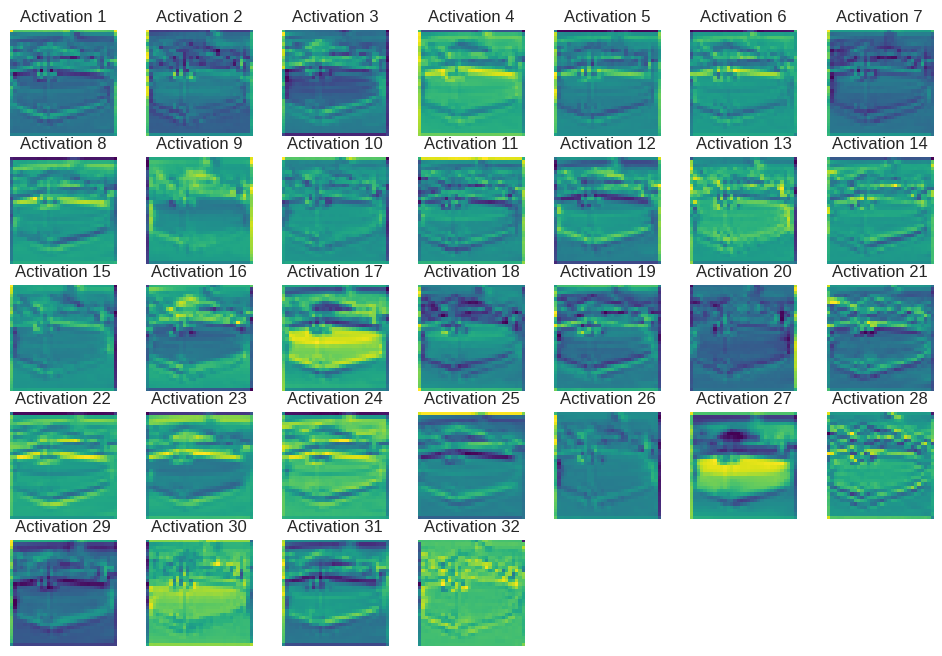

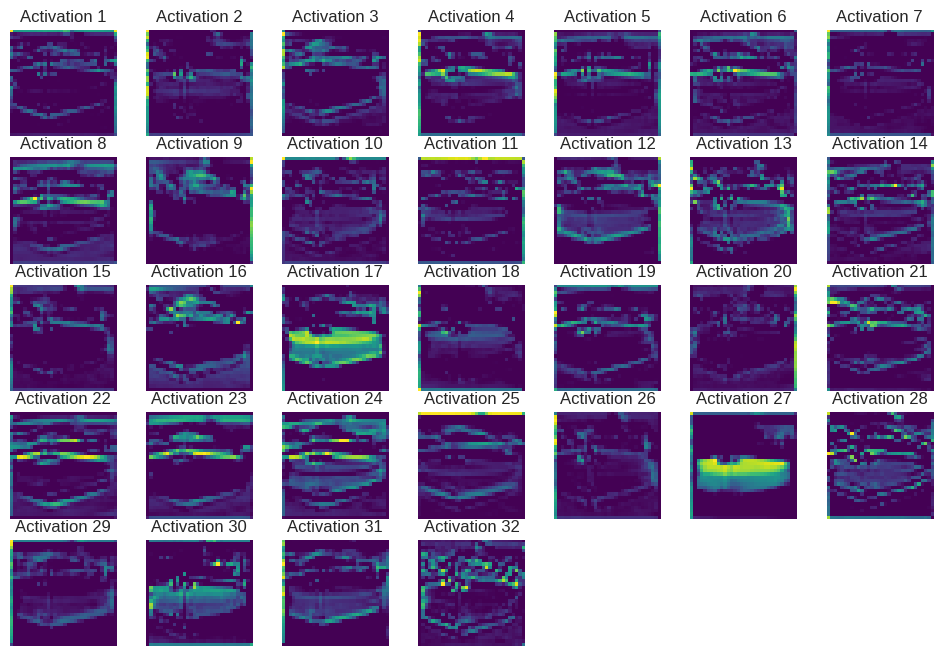

In [64]:
def visualize_activations(model, input_image, layer_num):
    activations = []

    # Register a hook to store the activations of the specified layer
    def hook_fn(module, input, output):
        activations.append(output)

    # Get the desired layer
    target_layer = model.conv_layer[layer_num]
    
    # Register the hook
    hook = target_layer.register_forward_hook(hook_fn)

    # Forward pass to get the activations
    with torch.no_grad():
        model(input_image.unsqueeze(0).to(device))

    # Remove the hook
    hook.remove()

    # Get the activations from the hook
    activations = activations[0].squeeze().cpu().numpy()

    # Visualize the activations
    num_activations = activations.shape[0]
    rows = int(np.sqrt(num_activations))
    cols = num_activations // rows + 1

    plt.figure(figsize=(12, 8))
    for i in range(num_activations):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(activations[i], cmap='viridis')
        plt.title(f'Activation {i+1}')
        plt.axis('off')

    plt.show()

# Choose an image from the dataset
sample_image, _ = next(iter(train_loader))

# Visualize activations from the first convolutional layer (index 0)
visualize_activations(cnn, sample_image[0], layer_num=0)

# Visualize activations from the second convolutional layer (index 1)
visualize_activations(cnn, sample_image[0], layer_num=1)


# Observations

Why Visualize Activation Maps?
Understanding Model Learning:

Activation maps show the response of different channels to specific features in the input.
Visualization helps you understand what kind of patterns or features each channel is learning.
Detecting Issues:Visual inspection can reveal issues like dead neurons (where activations are consistently zero) 
Activation maps provide insights into which parts of the input contribute to the model's decision.
This is especially important for interpretability in applications like image classification.

Improving Model:Visualization can guide model improvements by helping you understand what the network is focusing on and 
whether it aligns with your expectations.
Educational Purposes:Activation map visualization is a valuable educational tool for understanding 
how deep learning models work.


## 7. CNN without DropOut. Compare the results: training and validation loss, accuracy

In [65]:
class nodropoutCNN(nn.Module):           
    def __init__(self):
        super(nodropoutCNN, self).__init__()
    

        # Convolutional Layers
        self.conv_layer = nn.Sequential(
            
            # 1st Convolution Layer
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),         
            nn.ReLU(inplace=True),            

            # 2nd Convolution Layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  #. A kernelsize of 2 allows the pooling layer toretain important features. 

            # 3rd Convolution Layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),        

            # 4th Convolution Layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                      

            # 5th Convolution Layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 6th Convolution Layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), #spatial dimensions are reduced to 4×4 (for simplicity) and the number of channels is 256.
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Layers
        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 1024), #Input here is 4*4*256(4096) and output is 1024 or can use 2048.
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),    # 2048 to 1024
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)      #1024 to 10
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv_layer(x)
    
        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc_layer(x)

        return x
    
# Helper function to count the number of learnable parameters in the model
def count_model_params(model):
    """ Counting the number of learnable parameters in an nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Count parameters with gradients
    return num_params     

In [67]:
cnn = nodropoutCNN()
print(cnn)

nodropoutCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=Tru

In [69]:
LR = 0.001  # learning rate we can vary from 0.01 to 0.001
EPOCHS = 20
EVAL_FREQ = 1
SAVE_FREQ = 10

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

In [71]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [72]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [73]:
loss_tist = []
# Initialize dictionaries to store gradients
max_grads = {f'conv{i}': [] for i in range(1, 7)}
mean_grads = {f'conv{i}': [] for i in range(1, 7)}

for epoch in range(init_epoch, EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters, ie, Backward pass and Optiize
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Handling Gradients
        for name, param in cnn.named_parameters():
            if param.requires_grad and 'weight' in name:
                layer_number = None
                if 'conv_layer.0' in name:
                    layer_number = 1
                elif 'conv_layer.3' in name:
                    layer_number = 2
                elif 'conv_layer.6' in name:
                    layer_number = 3
                elif 'conv_layer.9' in name:
                    layer_number = 4
                elif 'conv_layer.12' in name:
                    layer_number = 5
                elif 'conv_layer.15' in name:
                    layer_number = 6

                if layer_number:
                    layer_key = f'conv{layer_number}'
                    mean_grads[layer_key].append(param.grad.abs().mean().item())
                    max_grads[layer_key].append(param.grad.abs().max().item())

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

    loss_tist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])

    # evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 1 Iter 49: loss 1.39596. : 100%|██████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.13it/s]


Accuracy at epoch 0: 49.14%


Epoch 2 Iter 49: loss 1.07291. : 100%|██████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.13it/s]


Accuracy at epoch 1: 60.77%


Epoch 3 Iter 49: loss 0.89499. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.06it/s]


Accuracy at epoch 2: 68.46%


Epoch 4 Iter 49: loss 0.69215. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.11it/s]


Accuracy at epoch 3: 73.31%


Epoch 5 Iter 49: loss 0.58576. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.11it/s]


Accuracy at epoch 4: 76.46%


Epoch 6 Iter 49: loss 0.50966. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.10it/s]


Accuracy at epoch 5: 77.68%


Epoch 7 Iter 49: loss 0.44232. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.11it/s]


Accuracy at epoch 6: 79.57%


Epoch 8 Iter 49: loss 0.30066. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.10it/s]


Accuracy at epoch 7: 80.29%


Epoch 9 Iter 49: loss 0.27349. : 100%|██████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.10it/s]


Accuracy at epoch 8: 80.72%


Epoch 10 Iter 49: loss 0.22654. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.03it/s]


Accuracy at epoch 9: 78.36%


Epoch 11 Iter 49: loss 0.20011. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.09it/s]


Accuracy at epoch 10: 81.71%


Epoch 12 Iter 49: loss 0.15477. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.08it/s]


Accuracy at epoch 11: 81.72%


Epoch 13 Iter 49: loss 0.13428. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.08it/s]


Accuracy at epoch 12: 81.61%


Epoch 14 Iter 49: loss 0.09555. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.08it/s]


Accuracy at epoch 13: 81.61%


Epoch 15 Iter 49: loss 0.06918. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.02it/s]


Accuracy at epoch 14: 81.62%


Epoch 16 Iter 49: loss 0.05092. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.04it/s]


Accuracy at epoch 15: 81.54%


Epoch 17 Iter 49: loss 0.05090. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.06it/s]


Accuracy at epoch 16: 81.39%


Epoch 18 Iter 49: loss 0.03561. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.06it/s]


Accuracy at epoch 17: 81.76%


Epoch 19 Iter 49: loss 0.04116. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.06it/s]


Accuracy at epoch 18: 81.53%


Epoch 20 Iter 49: loss 0.03720. : 100%|█████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.06it/s]


Accuracy at epoch 19: 81.88%


## 7.1 Training Validation and Accuracy graphs

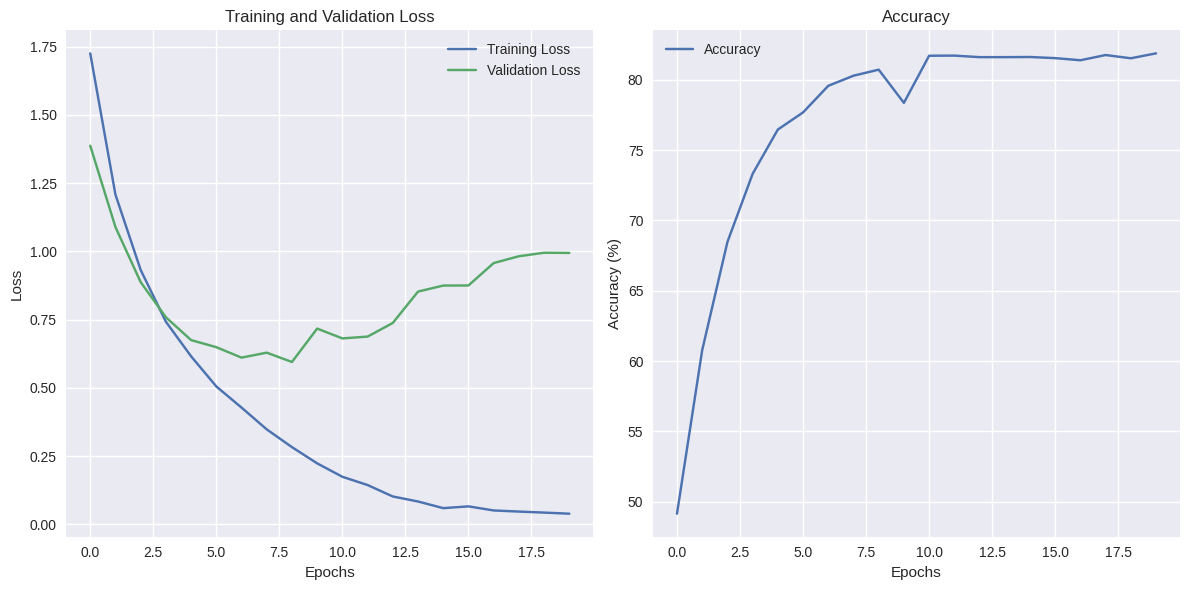

In [74]:
# Extract data from the stats dictionary
epochs = stats["epoch"]
train_loss = stats["train_loss"]
valid_loss = stats["valid_loss"]
accuracy = stats["accuracy"]

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# OBSERVATIONS

#1.Without dropouts 

    #1.there has been an increase in accuracy witnessed ABOVE 80%.
    
    #2.Validation loss increases larely after the 5th Higher Epochs
        #The sudden rise in validation loss after a certain number of epochs could be due to overfitting. 
        Overfitting occurs when a model learns not only the underlying patterns in the training data but also captures noise 
        and random fluctuations that are specific to the training set and do not generalize well to new, unseen data.
        
    #3. Soln is:
        #1.Insert nn.Dropout layers in the fully connected layers ..
        #2.Reduce the complexity of model
        #3.Data Augmentation here.
        #4.Using L2 regularization (weight_decay in the optimizer).
    



#2.With dropout values 
    #1.the accuracy has been reduced  to less than 80%.
    #2. Validation loss comes down.
    #3.Dropout introduces random noise during training by randomly "dropping out" (setting to zero) a fraction of the units 
    in layer. This prevents the model from relying too heavily on any particular set of features, making it more robust 
    and less likely to overfit.

## 7.2 After training, visualize the gradients:

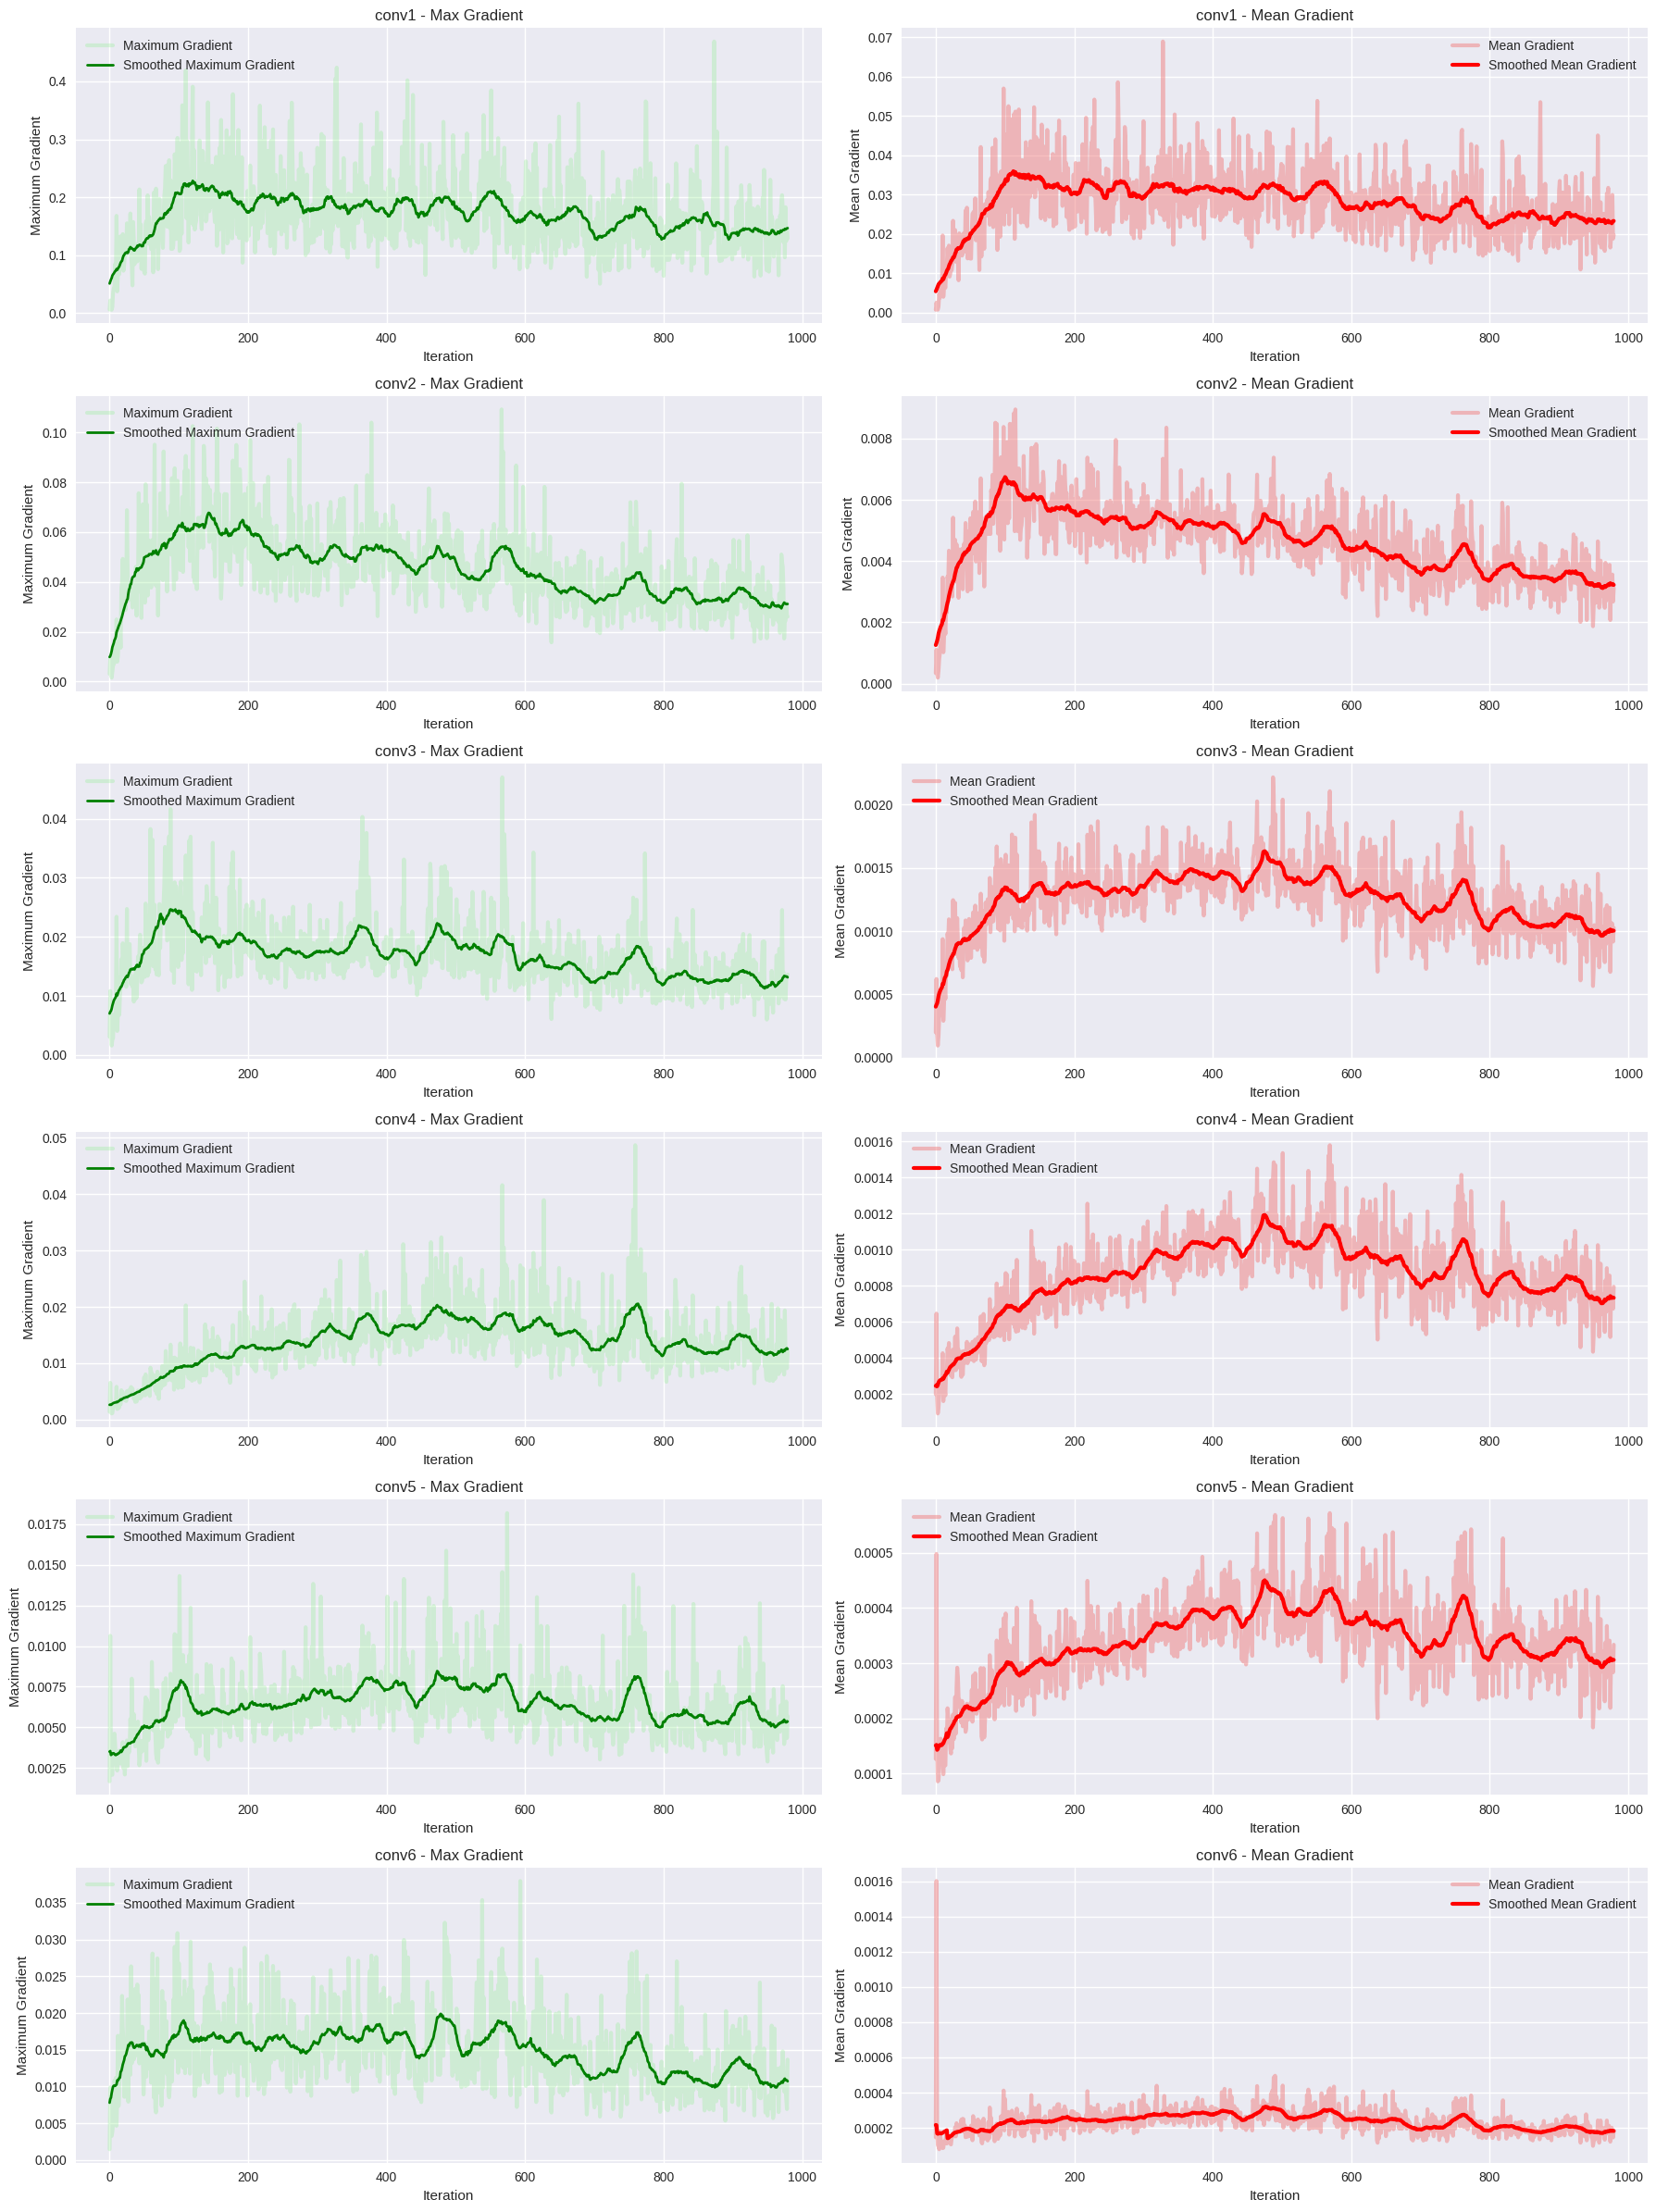

In [80]:
plt.style.use('seaborn')
fig, axes = plt.subplots(len(max_grads), 2, figsize=(18, len(max_grads) * 4))

for i, layer in enumerate(sorted(max_grads.keys())):
    # Apply smoothing function here if you have one
    smooth_max_grads = smooth(max_grads[layer], 31)  # Replace 'smooth' with your smoothing function if needed
    smooth_mean_grads = smooth(mean_grads[layer], 31)

    axes[i, 0].plot(max_grads[layer], c="lightgreen", label="Maximum Gradient", linewidth=3, alpha=0.3)
    axes[i, 0].plot(smooth_max_grads, c="green", label="Smoothed Maximum Gradient", linewidth=2)
    axes[i, 0].legend(loc="upper left")
    axes[i, 0].set_xlabel("Iteration")
    axes[i, 0].set_ylabel("Maximum Gradient")
    axes[i, 0].set_title(f"{layer} - Max Gradient")

    axes[i, 1].plot(mean_grads[layer], c="lightcoral", label="Mean Gradient", linewidth=3, alpha=0.5)
    axes[i, 1].plot(smooth_mean_grads, c="red", label="Smoothed Mean Gradient", linewidth=3)
    axes[i, 1].legend(loc="best")
    axes[i, 1].set_xlabel("Iteration")
    axes[i, 1].set_ylabel("Mean Gradient")
    axes[i, 1].set_title(f"{layer} - Mean Gradient")

plt.tight_layout()
plt.show()


# 7.3 Training Progress

NameError: name 'loss_tist' is not defined

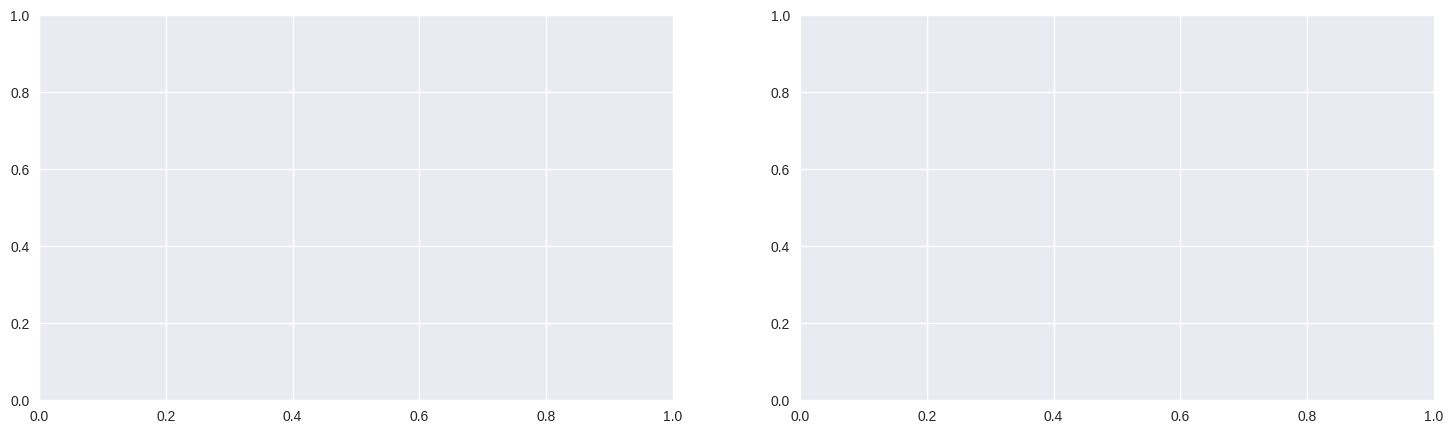

In [83]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_tloss = smooth(loss_tist, 31)
ax[0].plot(loss_tist, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_tloss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_tist, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_tloss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

## 7.4 Confusion Matrix

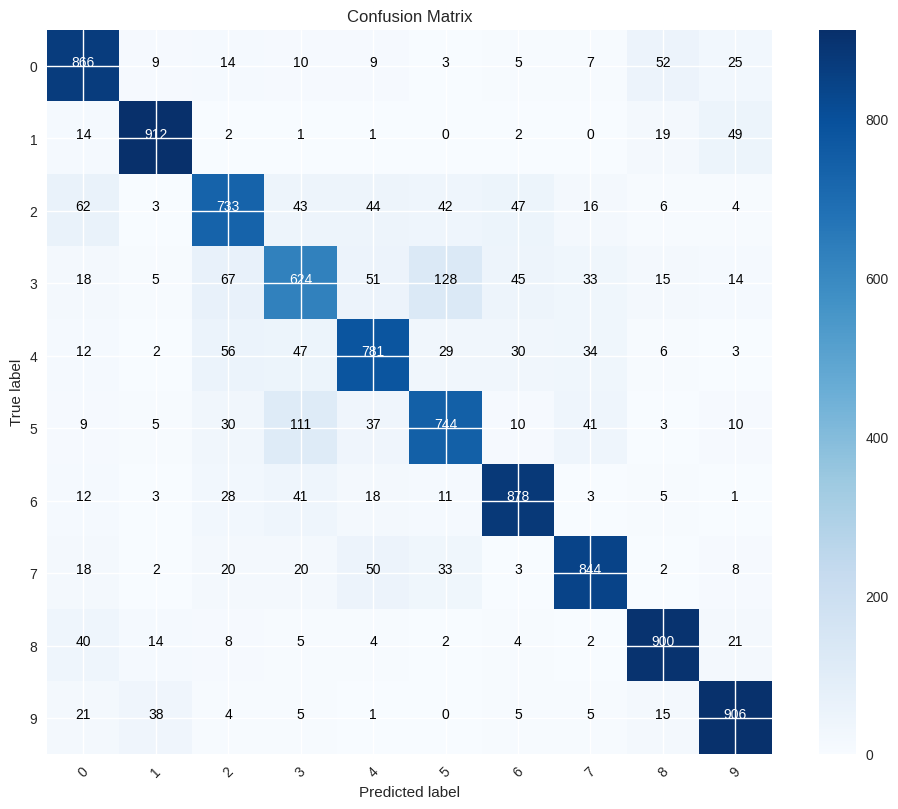

In [76]:
# Function to compute the confusion matrix
def compute_confusion_matrix(model, loader, device):
    confusion_matrix = torch.zeros(10, 10)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

# Compute confusion matrix for evaluation data
conf_matrix = compute_confusion_matrix(cnn, eval_loader, device)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting the confusion matrix
plot_confusion_matrix(conf_matrix.numpy(), [str(i) for i in range(10)])


# 8. Custom learning rate warmup and learning rate scheduler

Implement and use your own custom learning rate warmup and learning rate scheduler criterion to avoid overfitting.
It is not allowed to use PyTorch's schedulers, but you should code your own.
Train a model using it and show that you can mitigate overfitting.

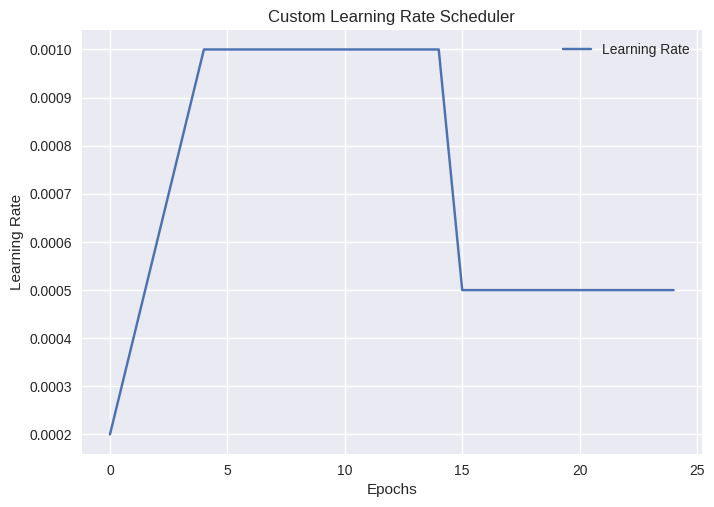

In [45]:

def custom_lr_scheduler(initial_lr, epoch, warmup_epochs=5, decay_factor=0.5, decay_interval=10):
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warm-up
        decay_multiplier = decay_factor ** ((epoch - warmup_epochs) // decay_interval)
        lr = initial_lr * decay_multiplier

    return lr


# Example usage
initial_lr = 0.001
num_epochs = 25

learning_rates = []
for epoch in range(num_epochs):
    lr = custom_lr_scheduler(initial_lr, epoch)
    learning_rates.append(lr)

# Plotting the learning rate schedule
plt.plot(range(num_epochs), learning_rates, label='Learning Rate')
plt.title('Custom Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


### Now we will implement in the CNN model and see how it goes.

In [46]:


def custom_lr_scheduler(optimizer, initial_lr, epoch, warmup_epochs=5, decay_factor=0.5, decay_interval=10):
    if not isinstance(optimizer, torch.optim.Optimizer):
        # If optimizer is not yet initialized, create a new one
        optimizer = torch.optim.Adam(params=cnn.parameters(), lr=initial_lr)

    if epoch < warmup_epochs:
        # Linear warm-up
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warm-up
        decay_multiplier = decay_factor ** ((epoch - warmup_epochs) // decay_interval)
        lr = initial_lr * decay_multiplier

    # Update optimizer learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer, lr

# Example usage in the training loop
optimizer = None  # Initialize optimizer to None before the loop because I am getting errors getting multiple times.
for epoch in range(init_epoch, EPOCHS):

    # Custom learning rate scheduler
    optimizer, current_lr = custom_lr_scheduler(optimizer, initial_lr=0.001, epoch=epoch, warmup_epochs=5, decay_factor=0.5, decay_interval=10)

    # evaluating model
    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        #print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

    # saving checkpoint
    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)


## 8.1 Accuracy and Validation loss over Epochs

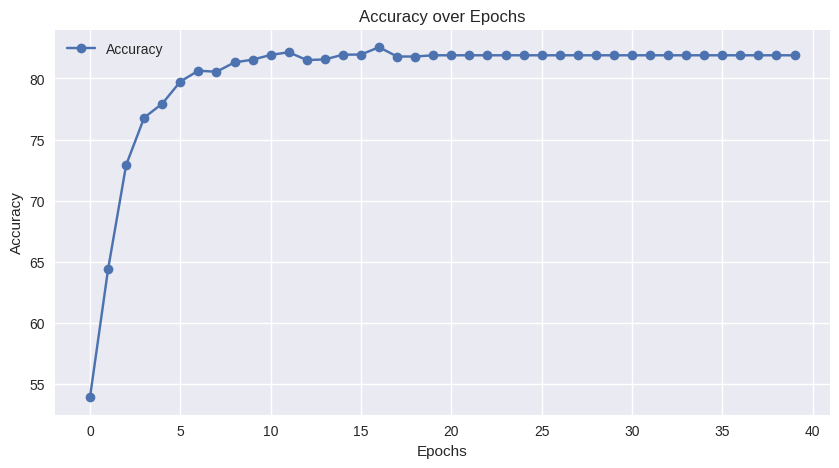

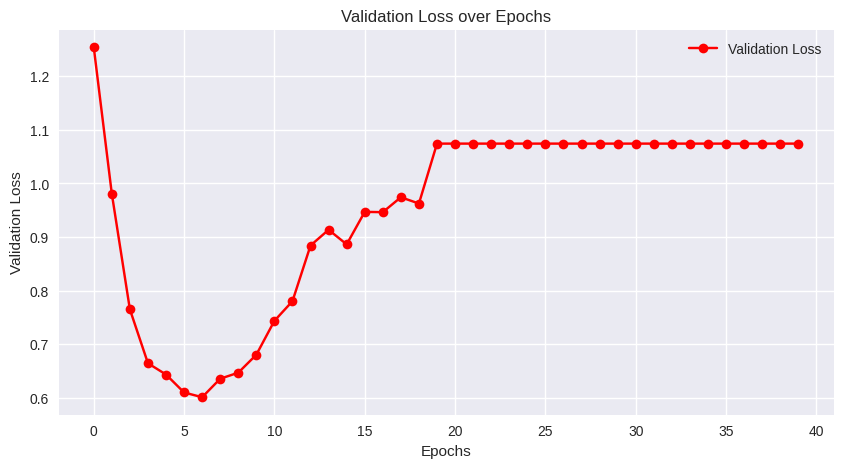

In [47]:
import matplotlib.pyplot as plt

# Assuming stats is a dictionary containing "accuracy" and "valid_loss" lists
accuracy = stats["accuracy"]
valid_loss = stats["valid_loss"]
epochs = range(init_epoch, init_epoch + len(accuracy))

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, valid_loss, label='Validation Loss', marker='o', color='r')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
